In [14]:
from utils import *
v = Voyager()

In [15]:
# read dataframe
data = pd.read_csv('./data/chicago_taxi/chicago_taxi_rides.csv')

# Predicting pickup density

## Some data engineering stuff


In [16]:
# data for pickup density prediction
pu = data[['trip_start_timestamp',
           'pickup_latitude',
           'pickup_longitude']]

In [17]:
# geohashing pickup coordinates
pu['geohash'] = pu.apply(lambda x: pgh.encode(x['pickup_latitude'],x['pickup_longitude'],precision=10),axis=1)

In [18]:
col = 'trip_start_' # prefix
tsd = col + 'timestamp' # starting column

''' extracting features from trip_start_timestamp column'''
pu[tsd] = pd.to_datetime(pu[tsd]).dt.tz_localize(None) # converting to datetime
pu[col + 'datetime'] = pd.to_datetime(pu[tsd].dt.strftime('%Y-%m-%d %H:00:00')) # converting to YYYY-MM-DD HH:00:00
pu[col + 'month'] = pu[tsd].dt.month.astype(np.int64) # extracting month
pu[col + 'week'] = pu[tsd].dt.strftime("%V").astype(np.int64)
# pu[col + 'day'] = pu[tsd].dt.day.astype(np.int64) # extracting day
pu[col + 'weekday'] = pu[tsd].dt.dayofweek.astype(np.int64) # extracting weekday 
pu[col + 'hour'] = pu[tsd].dt.strftime('%H').astype(np.int64) # extracting hour


In [19]:
# aggregating for pickup density calculation
pu = pu.drop(columns=['pickup_latitude',
                 'pickup_longitude']). \
                     groupby(['geohash',
                              'trip_start_datetime',
                              'trip_start_month',
                              'trip_start_week',
                              'trip_start_weekday',
                              'trip_start_hour'],as_index=False)['trip_start_timestamp'].count().\
                                  rename(columns={'trip_start_timestamp':'number_of_rides'})

In [20]:
''' Sine and cosine transformation '''
pu['trip_start_sin_hour'] = np.sin(2*np.pi*pu['trip_start_hour']/24) # sin hour transformation
pu['trip_start_cos_hour'] = np.cos(2*np.pi*pu['trip_start_hour']/24) # cos hour transformation
pu['trip_start_sin_month'] = np.sin(2*np.pi*pu['trip_start_month']/12) # sin month transformation
pu['trip_start_cos_month'] = np.cos(2*np.pi*pu['trip_start_month']/12) # cos month transformation
pu['trip_start_sin_week'] = np.sin(2*np.pi*pu['trip_start_week']/52) # sin week transformation
pu['trip_start_cos_week'] = np.cos(2*np.pi*pu['trip_start_week']/52) # cos week transformation
pu['trip_start_sin_week'] = np.sin(2*np.pi*pu['trip_start_weekday']/7) # sin weekday transformation
pu['trip_start_cos_week'] = np.cos(2*np.pi*pu['trip_start_weekday']/7) # cos weekday transformation

In [21]:
# weekend dummy (monday:0)
pu['trip_start_weekend_dummy'] = pu['trip_start_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

In [22]:
pu.head(2)

,geohash,trip_start_datetime,trip_start_month,trip_start_week,trip_start_weekday,trip_start_hour,number_of_rides,trip_start_sin_hour,trip_start_cos_hour,trip_start_sin_month,trip_start_cos_month,trip_start_sin_week,trip_start_cos_week,trip_start_weekend_dummy
0,dp3qz6r2b0,2022-04-24 00:00:00,4,16,6,0,4,0.000000,1.000000,0.866025,-0.5,-0.781831,0.62349,1
1,dp3qz6r2b0,2022-04-24 01:00:00,4,16,6,1,2,0.258819,0.965926,0.866025,-0.5,-0.781831,0.62349,1


### About sine and cosine transformation of cyclical numerical features

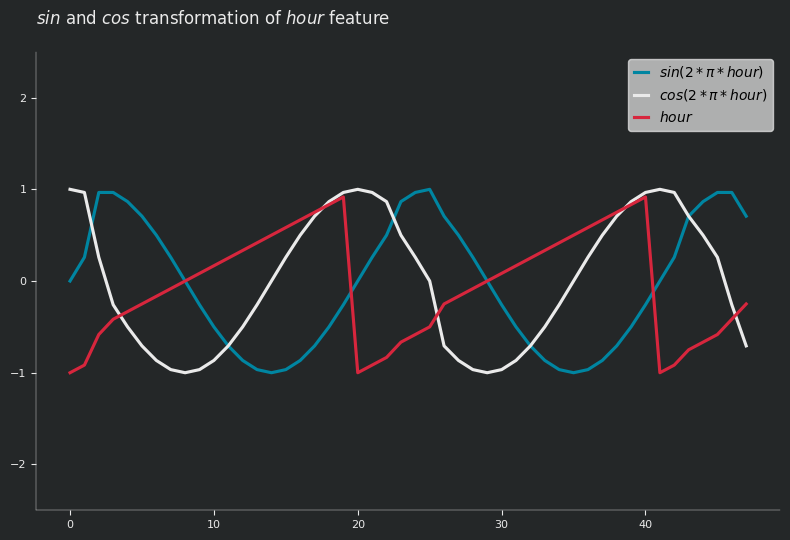

In [30]:
'''sine and cosine transformation temporary plot'''
_t = pu
def normalize_hours(hour):
    hour -= 12 # subtracting 12 from hours to get a value between -12 and 11.
    hour /= 12 # divide the hour by 12 to get a value between -1 and 1.
    return hour
_t['trip_start_normalized_hour'] = _t['trip_start_hour'].apply(normalize_hours)
_t = _t[['trip_start_sin_hour',
         'trip_start_cos_hour',
         'trip_start_normalized_hour']].head(48)
# plot
_t.plot()
plt.title('$sin$ and $cos$ transformation of $hour$ feature')
plt.legend(['$sin(2*\pi*hour)$','$cos(2*\pi*hour)$','$hour$'])
plt.ylim(-2.5,2.5)
plt.show()

## Weather data from copernicus

In [25]:
# # reading netcdf files
# cw_files = glob.glob('./data/chicago_taxi/chicago_weather/*.nc')
# cw = pd.concat([v.copernicus_to_dataframe(file_path=f) for f in cw_files])

# # renaming columns (time for merge)
# cw.rename(columns={
#     'time':'trip_start_datetime',
#     't2m':'temperature',
#     'ptype':'precipitation_type',
#     'tp':'total_precipitation',
#     'u10':'10m_eastward_wind',
#     'v10':'10m_northward_wind'
# },inplace=True)

# # drop column useless
# cw.drop(columns='expver',inplace=True)

# # clean temperature and precipitation type
# cw['temperature'] = cw['temperature'] - 273.15
# cw['precipitation_type'] = cw['precipitation_type'].fillna(0)
# cw['precipitation_type'] = round(cw['precipitation_type']).astype(np.int64)

# # interpolate 3 points
# cw = cw.drop(columns=['latitude','longitude']).groupby('trip_start_datetime',as_index=False).mean()